In [257]:
%load_ext autoreload
%autoreload 2
import numpy as np
import os
import sys
import time
sys.path.append('../')
sys.path.append('/usr/users/fsimone/tejaas')
import json
import os 
from utils import utils
import pandas as pd
tissue_file = "/usr/users/fsimone/trans-eqtl-pipeline/main/tissues.txt"
tissues, descriptions = utils.read_tissues(tissue_file)

MAF = 0.01
mafdir = "maf{:g}".format(MAF*100)
basepath = "/cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v8_lncRNA_freeze/"


json_file = "../gtex_v8_metadata.json"
with open(json_file) as instream:
    gtex_meta = json.load(instream)
tissue_colors = dict()
tissue_names = dict()
tissue_samples = dict()
for tshort, tfull in zip(tissues, descriptions):
    tissue_names[tshort] = tfull
    tissue_colors[tshort] = "#" + gtex_meta[tfull.replace(" ", "_")]["colorHex"]
    tissue_samples[tshort] = gtex_meta[tfull.replace(" ", "_")]["rnaSeqAndGenotypeSampleCount"]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [258]:
MIN_COUNTS = 10

# Load cis-eQTL enrichments (for our matrixeqtl cis-eqtls)
cisfilename = os.path.join(basepath, "cis_eqtls_analysis", mafdir, "CisEQTL_enrichment_results_"+mafdir+".txt")
df_cis = pd.read_csv(cisfilename, sep="\t", header= None)
df_cis.columns = ["tissue", "ncis", "ntrans", "ncistrans", "rand_frac", "cis_enrichment", "pval"]
df_cis.index = df_cis.tissue
print("{:d} Tissues evaluated".format(len(df_cis.index)))
df_cis = df_cis[df_cis.ncistrans >= MIN_COUNTS] 
print("{:d} Tissues remain after count filtering".format(len(df_cis.index)))

41 Tissues evaluated
29 Tissues remain after count filtering


In [259]:
# Load enrichments for genetypes
cistypefilename = os.path.join(basepath, "cis_eqtls_analysis", mafdir, "CisEQTL_target_enrichment_results_"+mafdir+".txt")
df_type         = pd.read_csv(cistypefilename, sep="\t", header= None)
df_type.columns = ["tissue", "genetype", "etype", "hits", "rand_frac", "enrichment", "pval"]

# select only some tissues and by count number

# [x in df_cis.tissue for x in df_type.tissue] 
df_type = df_type[df_type.hits > MIN_COUNTS ]

# select enrichment type (CIS or RANDOM)
cis_type_df = df_type[df_type.etype.str.match("RANDOM")][["tissue", "genetype", "enrichment"]]
cis_type_df.index = cis_type_df.tissue


enrich_matrix = cis_type_df.pivot(index='tissue', columns="genetype").enrichment
enrich_matrix

genetype,3prime_overlapping_ncRNA,TF,antisense,lincRNA,processed_transcript,protein_coding,sense_intronic,sense_overlapping
tissue,,,,,,,,
aa,NaN,1.771387,2.004655,2.200416,5.975143,1.761967,NaN,NaN
ac,NaN,1.642627,2.889085,2.387933,5.549014,1.768953,NaN,NaN
ag,NaN,7.313341,NaN,NaN,NaN,1.974620,NaN,NaN
as,NaN,NaN,0.507635,NaN,NaN,0.823829,NaN,NaN
at,NaN,NaN,0.873004,NaN,NaN,1.072528,NaN,NaN
av,NaN,1.066202,2.669072,1.412619,NaN,1.722296,NaN,NaN
bam,NaN,3.260448,0.724744,1.600597,NaN,1.071002,NaN,NaN
ban,NaN,0.721111,NaN,NaN,NaN,0.439068,NaN,NaN
bco,NaN,NaN,NaN,NaN,NaN,1.674725,NaN,NaN


In [260]:
import fastcluster
from scipy.cluster import hierarchy

def calculate_linkage(matrix):
    data = matrix
#     row_linkage = fastcluster.linkage_vector(data.fillna(0).values,
#                                method='single',
#                                metric="euclidean")
# #     row_linkage = hierarchy.linkage(data.fillna(0), method="average", metric='euclidean')

#     row_dendrogram = hierarchy.dendrogram(row_linkage, no_plot=True, color_threshold=-np.inf)
#     row_reordered_ind = row_dendrogram['leaves']

    data = matrix.T
    col_linkage = fastcluster.linkage_vector(data.fillna(0).values,
                               method='single',
                               metric="euclidean")
#     col_linkage = hierarchy.linkage(data.fillna(0), method="average", metric='euclidean')
    
    col_dendrogram = hierarchy.dendrogram(col_linkage, no_plot=True, color_threshold=-np.inf)
    col_reordered_ind = col_dendrogram['leaves']
    # return matrix.iloc[row_reordered_ind, col_reordered_ind]
    return matrix.iloc[:, col_reordered_ind]

In [261]:
# Load cis-SQTL enrichments (for GTEx Portal cisSQTLs)

cisfilename = os.path.join(basepath, "GTExPortal_sqtl_analysis", mafdir, "CisSQTL_enrichment_results_"+mafdir+".txt")
df_cis_gtex_sqtl = pd.read_csv(cisfilename, sep="\t", header= None)
df_cis_gtex_sqtl.columns = ["tissue", "ncis", "ntrans", "ncistrans", "rand_frac", "gtex_sqtl_enrichment", "pval"]
df_cis_gtex_sqtl.index = df_cis_gtex_sqtl.tissue

df_cis_gtex_sqtl = df_cis_gtex_sqtl[ df_cis_gtex_sqtl.ncistrans >= MIN_COUNTS ]

# Load enrichments for genetypes
# cistypefilename = os.path.join(basepath, "GTExPortal_sqtl_analysis", mafdir, "CisSQTL_target_enrichment_results_"+mafdir+".txt")
# df_type = pd.read_csv(cistypefilename, sep="\t", header= None)
# df_type.columns = ["tissue", "genetype", "etype", "hits", "rand_frac", "enrichment", "pval"]
# cis_type_df = df_type[df_type.etype.str.match("RANDOM")][["tissue", "genetype", "enrichment"]]
# cis_type_df.index = cis_type_df.tissue
# enrich_matrix = cis_type_df.pivot(index='tissue', columns="genetype")

# data = calculate_linkage(enrich_matrix)
# DATA = pd.concat([df_cis_gtex_sqtl.loc[enrich_matrix.index].gtex_sqtl_enrichment, enrich_matrix.enrichment], axis=1, sort=False)
# DATA = DATA.T
# DATA

In [262]:
# Load cis-eQTL enrichments (for GTEx Portal ciseQTLs)

cisfilename      = os.path.join(basepath, "GTExPortal_eqtl_analysis", mafdir, "CisEQTL_enrichment_results_"+mafdir+".txt")
df_cis_gtex_eqtl = pd.read_csv(cisfilename, sep="\t", header= None)
df_cis_gtex_eqtl.columns = ["tissue", "ncis", "ntrans", "ncistrans", "rand_frac", "gtex_eqtl_enrichment", "pval"]
df_cis_gtex_eqtl.index   = df_cis_gtex_eqtl.tissue

df_cis_gtex_eqtl = df_cis_gtex_eqtl[ df_cis_gtex_eqtl.ncistrans >= MIN_COUNTS ]

# Load enrichments for genetypes
# cistypefilename = os.path.join(basepath, "GTExPortal_eqtl_analysis", mafdir, "CisEQTL_target_enrichment_results_"+mafdir+".txt")
# df_type = pd.read_csv(cistypefilename, sep="\t", header= None)
# df_type.columns = ["tissue", "genetype", "etype", "hits", "rand_frac", "enrichment", "pval"]
# cis_type_df = df_type[df_type.etype.str.match("RANDOM")][["tissue", "genetype", "enrichment"]]
# cis_type_df.index = cis_type_df.tissue
# enrich_matrix = cis_type_df.pivot(index='tissue', columns="genetype")

# data = calculate_linkage(enrich_matrix)
# DATA = pd.concat([df_cis_gtex_eqtl.loc[enrich_matrix.index].gtex_eqtl_enrichment, enrich_matrix.enrichment], axis=1, sort=False)
# DATA = DATA.T
# DATA

In [266]:
data = calculate_linkage(enrich_matrix)
# DATA = pd.concat([df_cis.loc[data.index].cis_enrichment, data.enrichment], axis=1, sort=False)

df_cis_gtex_eqtl[df_cis_gtex_eqtl.gtex_eqtl_enrichment == 0] = np.nan
df_cis_gtex_sqtl[df_cis_gtex_sqtl.gtex_sqtl_enrichment == 0] = np.nan

# DATA = pd.concat([enrich_matrix.enrichment, df_cis.loc[enrich_matrix.index].cis_enrichment], axis=1, sort=False)
empty_df = pd.DataFrame([np.nan for i in range(0, enrich_matrix.shape[0])], index = enrich_matrix.index)
empty_df.columns = ["tmp"]

DATA = pd.concat([calculate_linkage(enrich_matrix), 
                  empty_df, 
                  df_cis.loc[enrich_matrix.index].cis_enrichment,
                  df_cis_gtex_eqtl.gtex_eqtl_enrichment,
                  df_cis_gtex_sqtl.gtex_sqtl_enrichment], axis=1, sort=False, join='outer')
# DATA = pd.concat([DATA, empty_df, df_cis_gtex_sqtl.loc[DATA.index].gtex_sqtl_enrichment, df_cis_gtex_eqtl.loc[DATA.index].gtex_eqtl_enrichment], axis=1, sort=False, join='outer')
DATA = DATA.T

In [267]:
DATA

,aa,ac,ag,as,at,av,bam,ban,bco,bhi,...,nt,si,snse,sse,sto,thy,pro,tes,ut,ov
3prime_overlapping_ncRNA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,389.408100,NaN,NaN,NaN,NaN,NaN,NaN
TF,1.771387,1.642627,7.313341,NaN,NaN,1.066202,3.260448,0.721111,NaN,NaN,...,0.294298,NaN,2.694444,1.520921,2.137905,1.137171,NaN,NaN,NaN,NaN
processed_transcript,5.975143,5.549014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2.240594,NaN,16.286090,NaN,NaN,NaN,NaN,NaN
sense_intronic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2.584243,NaN,NaN,NaN,NaN
sense_overlapping,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,3.677641,NaN,NaN,NaN,NaN
protein_coding,1.761967,1.768953,1.974620,0.823829,1.072528,1.722296,1.071002,0.439068,1.674725,1.475109,...,0.576984,1.149382,1.981930,1.964719,2.633382,0.759857,NaN,NaN,NaN,NaN
antisense,2.004655,2.889085,NaN,0.507635,0.873004,2.669072,0.724744,NaN,NaN,NaN,...,0.520959,NaN,2.762283,3.680529,2.126878,0.332894,NaN,NaN,NaN,NaN
lincRNA,2.200416,2.387933,NaN,NaN,NaN,1.412619,1.600597,NaN,NaN,NaN,...,NaN,NaN,0.871146,2.269058,5.804860,0.664756,NaN,NaN,NaN,NaN
tmp,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cis_enrichment,1.683427,1.669100,1.852158,0.778515,1.018226,1.654433,1.009801,0.404716,1.614046,1.684850,...,0.542898,1.049877,1.891402,1.953922,2.537927,0.718642,NaN,NaN,NaN,NaN


In [32]:
# DATA = calculate_linkage(DATA)

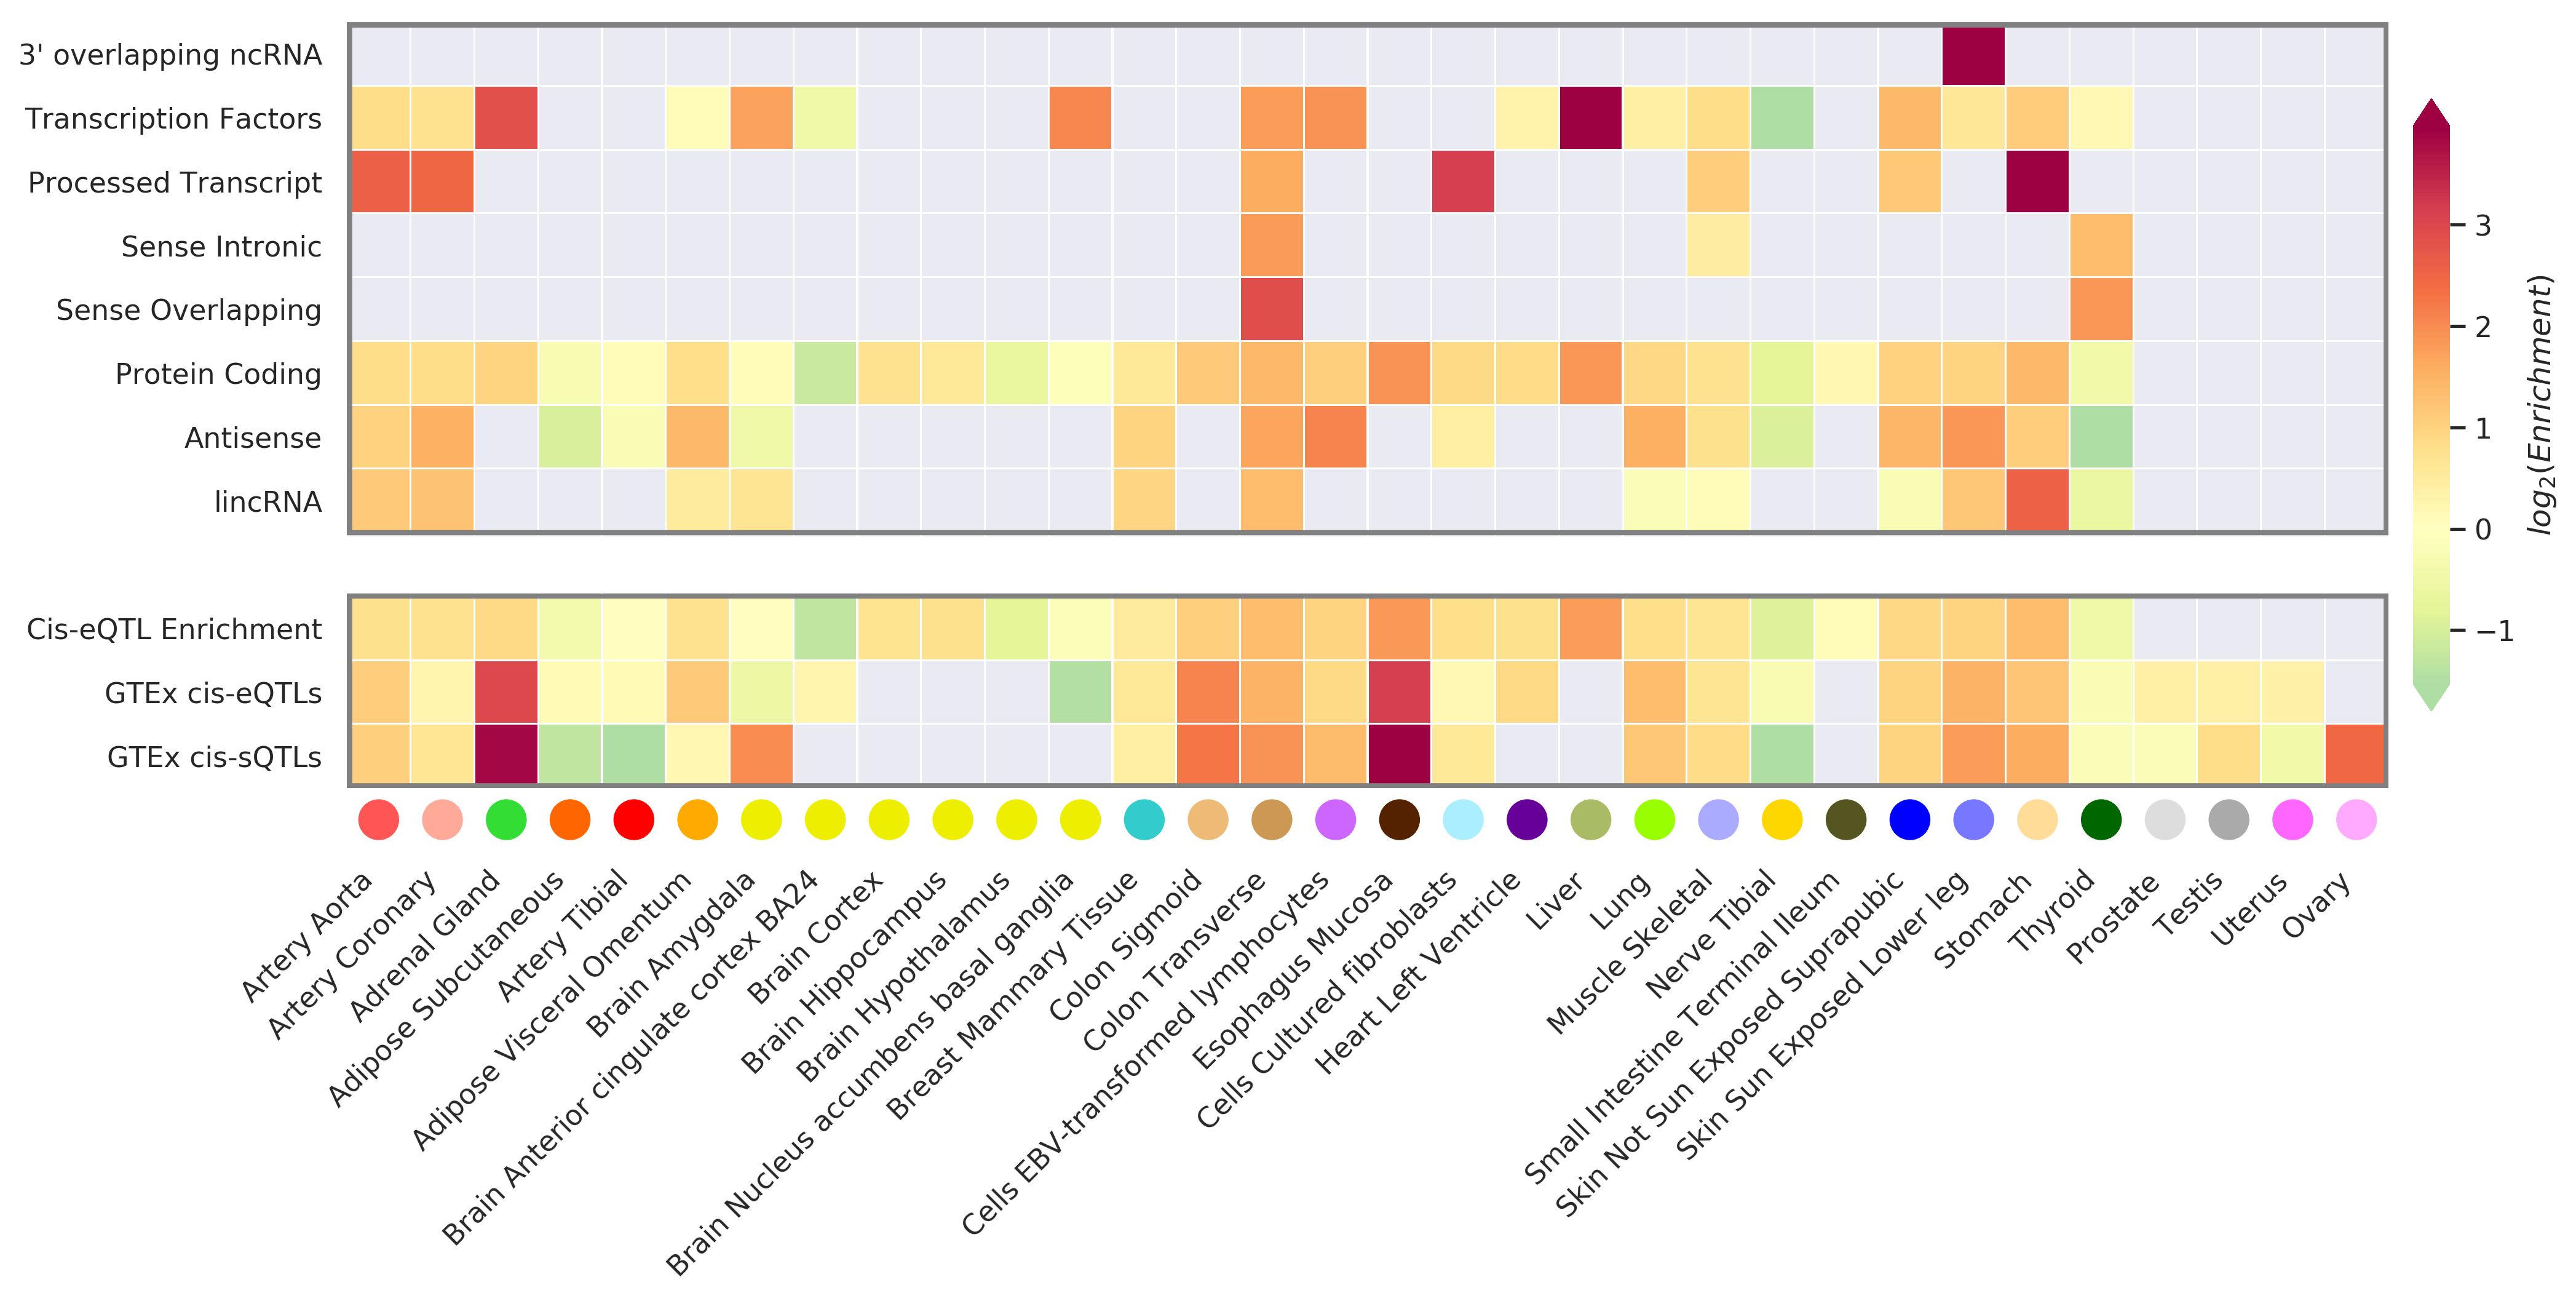

In [305]:
import matplotlib
# matplotlib.use("Agg")
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns; sns.set()

# fig = plt.figure(figsize=(14,17))  
fig = plt.figure(figsize=(17,8), dpi=300)  
ax  = fig.add_subplot(111)
# cbar_ax = fig.add_axes([.905, .3, .05, .3])
cmap = plt.get_cmap("RdBu_r")

mymask = pd.isna(DATA)
mymask.loc["tmp"] = False
# cmap.set_bad("gray")

h = sns.heatmap(np.log2(DATA),
                cmap=cmap, #"RdBu_r",
                robust=True,
                linewidths=.5,
                center=0.0,
                cbar_kws={'label': '$log_2(Enrichment)$', 'shrink':0.55,
                          #'ticks':[-2.0,-1.0, 0.0, 1.0, 2.0, 3.0, 4.0],
                          'extend':'both',
                          'pad':0.01,
                          'aspect':15},
                ax=ax,
                mask=mymask)
#                 cbar_ax = cbar_ax)
# h.set_facecolor('white')


# cbar=plt.colorbar(ax)
# cbar.set_yticklabels(["a","a","a","a","a","a"])
# h.figure.axes[1].set_yticklabels(["-2","-1","0","1","2","3","> 4"])

ylabels = ["3' overlapping ncRNA", "Transcription Factors", "Processed Transcript", "Sense Intronic", "Sense Overlapping", "Protein Coding", "Antisense", "lincRNA", "", "Cis-eQTL Enrichment", "GTEx cis-eQTLs", "GTEx cis-sQTLs"]
for l in DATA.index:
    if l == "tmp":
        ylabels.append("")
    else:
        ylabels.append(l)
ax.set_yticklabels(ylabels, rotation="horizontal")
ax.set_xticklabels(DATA.columns, rotation=90) #, ha='right')
ax.hlines([ax.get_ylim()[0]-3], *ax.get_xlim(), color='gray', lw=2)
ax.hlines([ax.get_ylim()[0]]  , *ax.get_xlim(), color='gray', lw=4)
ax.vlines([0,ax.get_xlim()[1]], ax.get_ylim()[0]-3, ax.get_ylim()[0], color='gray', lw=4)

ax.hlines([ax.get_ylim()[0]-4], *ax.get_xlim(), color='gray', lw=2)
ax.hlines([ax.get_ylim()[1]]  , *ax.get_xlim(), color='gray', lw=4)
ax.vlines([0,ax.get_xlim()[1]], ax.get_ylim()[0]-4, ax.get_ylim()[1], color='gray', lw=4)


ax.hlines([ax.get_ylim()[0]-3.5]  , *ax.get_xlim(), color='white', lw=22)

# cbar = ax.figure.colorbar(im, ax=ax)
# cbar.ax.set_ylabel("AUC", rotation=-90, va="bottom")

my_colors=[tissue_colors[t] for t in DATA.columns]
ax.set_aspect('equal')
for t, X in zip(DATA.columns, ax.get_xticks()):
    ax.add_patch(patches.Circle((X, len(DATA.index)+0.5), radius=.3,
                                 fill=True,clip_on=False, color=tissue_colors[t]))
    
labels = ax.get_xticklabels()
for label in labels:
    label.set_y(label.get_position()[1] - 0.07 )

ax.set_xticklabels([tissue_names[l.get_text()] for l in labels], rotation=45, ha='right')

plt.show()
# plt.savefig("heatmap.png")

['3prime_overlapping_ncRNA',
 'TF',
 'processed_transcript',
 'sense_intronic',
 'sense_overlapping',
 'protein_coding',
 'antisense',
 'lincRNA',
 '',
 'cis_enrichment',
 'gtex_eqtl_enrichment',
 'gtex_sqtl_enrichment']

In [303]:
# Load cis-eQTL enrichments (for GTEx Portal ciseQTLs)

cisfilename      = os.path.join(basepath, "GTExPortal_eqtl_analysis", mafdir, "CisEQTL_enrichment_results_"+mafdir+".txt")
df_cis_gtex_eqtl = pd.read_csv(cisfilename, sep="\t", header= None)
df_cis_gtex_eqtl.columns = ["tissue", "ncis", "ntrans", "ncistrans", "rand_frac", "gtex_eqtl_enrichment", "pval"]
df_cis_gtex_eqtl.index   = df_cis_gtex_eqtl.tissue

df_cis_gtex_eqtl = df_cis_gtex_eqtl[ df_cis_gtex_eqtl.ncistrans >= MIN_COUNTS ]

# Load enrichments for genetypes
cistypefilename = os.path.join(basepath, "GTExPortal_eqtl_analysis", mafdir, "CisEQTL_target_enrichment_results_"+mafdir+".txt")
df_type         = pd.read_csv(cistypefilename, sep="\t", header= None)
df_type.columns = ["tissue", "genetype", "etype", "hits", "rand_frac", "enrichment", "pval"]

# select only some tissues and by count number
df_type = df_type[df_type.hits > MIN_COUNTS ]

# select enrichment type (CIS or RANDOM)
cis_type_df = df_type[df_type.etype.str.match("RANDOM")][["tissue", "genetype", "enrichment"]]
cis_type_df.index = cis_type_df.tissue


enrich_matrix = cis_type_df.pivot(index='tissue', columns="genetype").enrichment

empty_df = pd.DataFrame([np.nan for i in range(0, enrich_matrix.shape[0])], index = enrich_matrix.index)
empty_df.columns = ["tmp"]

DATA = pd.concat([calculate_linkage(enrich_matrix), 
                  empty_df,
                  df_cis_gtex_eqtl.loc[enrich_matrix.index].gtex_eqtl_enrichment], 
                  axis=1, sort=False, join='outer')
DATA = DATA.T

fig = plt.figure(figsize=(17,8), dpi=300)  
ax  = fig.add_subplot(111)
cmap = plt.get_cmap("RdBu_r")
#cmap.set_bad("white")
h = sns.heatmap(np.log2(DATA),
                cmap=cmap, #"RdBu_r",
                robust=True,
                linewidths=.5,
                center=0.0,
                cbar_kws={'label': '$log_2(Enrichment)$', 'shrink':0.55,
                          'extend':'both',
                          'pad':0.01,
                          'aspect':15},
                ax=ax,
                mask=pd.isna(DATA))

# h.figure.axes[1].set_yticklabels(["-2","-1","0","1","2","3","> 4"])

ylabels = list()
for l in DATA.index:
    if l == "tmp":
        ylabels.append("")
    else:
        ylabels.append(l)
ax.set_yticklabels(ylabels, rotation="horizontal")
ax.set_xticklabels(DATA.columns, rotation=90) #, ha='right')
ax.hlines([ax.get_ylim()[0]-1], *ax.get_xlim(), color='gray', lw=2)
ax.hlines([ax.get_ylim()[0]]  , *ax.get_xlim(), color='gray', lw=4)
ax.vlines([0,ax.get_xlim()[1]], ax.get_ylim()[0]-1, ax.get_ylim()[0], color='gray', lw=4)

ax.hlines([ax.get_ylim()[0]-2], *ax.get_xlim(), color='gray', lw=2)
ax.hlines([ax.get_ylim()[1]]  , *ax.get_xlim(), color='gray', lw=4)
ax.vlines([0,ax.get_xlim()[1]], ax.get_ylim()[0]-2, ax.get_ylim()[1], color='gray', lw=4)

# cbar = ax.figure.colorbar(im, ax=ax)
# cbar.ax.set_ylabel("AUC", rotation=-90, va="bottom")

my_colors=[tissue_colors[t] for t in DATA.columns]
ax.set_aspect('equal')
for t, X in zip(DATA.columns, ax.get_xticks()):
    ax.add_patch(patches.Circle((X, len(DATA.index)+0.5), radius=.3,
                                 fill=True,clip_on=False, color=tissue_colors[t]))
    
labels = ax.get_xticklabels()
for label in labels:
    label.set_y(label.get_position()[1] - 0.07 )

ax.set_xticklabels([tissue_names[l.get_text()] for l in labels], rotation=45, ha='right')

plt.show()

FileNotFoundError: File b'/cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v8_lncRNA_freeze/GTExPortal_eqtl_analysis/maf1/CisEQTL_target_enrichment_results_maf1.txt' does not exist